# Subpixel Matching - Part II

In [1]:
import math
import os
import sys

sys.path.insert(0, os.path.abspath('/data/autocnet'))

import autocnet
# Enable the GPU
autocnet.cuda(enable=True)

from autocnet import CandidateGraph

# The GPU based extraction library that contains SIFT extraction and matching
import cudasift as cs
# A method to resize the images on the fly.
from scipy.misc import imresize

%pylab inline
figsize(16,4)

Populating the interactive namespace from numpy and matplotlib


## Create the CandidateGraph
Just like the other notebooks this cell creates the candidate graph.  This also patches in functionality to the object on the fly.  To get a handle on what is going on, checkout the [Advanced 1. Extending the CandidateGraph](Advanced 1. Extending the CandidateGraph.ipynb) notebook.

In [2]:
# Create the candidate graph and enable a GPU
a = 'AS15-P-0111_CENTER_LRG_CROPPED.png'
b = 'AS15-P-0112_CENTER_LRG_CROPPED.png'

adj = {a:[b],
       b:[a]}

cg = CandidateGraph.from_adjacency(adj)

# Define a function to do the feature extraction.
def extract_features(self, arr, downsample_amount=None, **kwargs):
    total_size = arr.shape[0] * arr.shape[1]
    if not downsample_amount:
        downsample_amount = math.ceil(total_size / 12500**2)
    shape = (int(arr.shape[0] / downsample_amount), int(arr.shape[1] / downsample_amount))
    # Downsample
    arr = imresize(arr, shape, interp='lanczos')
    
    npts = max(arr.shape) / 3.5
    sd = cs.PySiftData(npts)
    cs.ExtractKeypoints(arr, sd, **kwargs)
    kp, des = sd.to_data_frame()
    kp = kp[['x', 'y', 'scale', 'sharpness', 'edgeness', 'orientation', 'score', 'ambiguity']]
    kp['score'] = 0.0
    kp['ambiguity'] = 0.0
    
    # Match the interface defined in the edge.
    self.keypoints = kp
    self.descriptors = des
    
    self['downsample_amount'] = downsample_amount

# Import the class and update it.  This updates the current instance of the CandidateGraph
from autocnet.graph.node import Node
Node.extract_features = extract_features

# Extract the features
cg.extract_features(thresh=1)

## Match and Find Outliers

In [3]:
# Match
cg.match()

# Apply outlier detection - see the above linked notebook if you are curious about what is going on here.
for s,d,e in cg.edges_iter(data=True):
    e.masks['ratio'] = e.matches.ambiguity <= e.matches.ambiguity.quantile(0.015)
    e.masks['score'] = e.matches.score >= e.matches.score.quantile(0.85)
    
# Compute the F Matrix
cg.compute_fundamental_matrices(clean_keys=['ratio', 'score'])

## Subpixel Refinement

The last notebook looked at the results of subpixel refinement to explore the result quality.  In this notebook, subpixel refinement is simply applied using the built-in syntax sugar.

**Caveat**: AutoCNet does not (yet?) natively support up and down sampling so the user has to manually rescale the correspondences.  The dev. team is thinking about if, and how best to implement multi-resolution tracking without adding lots of complexity.

#### Subpixel Parameters :
Since the Apollo Pan data was originally processed at a reduced resolution, the `max_x_shift` and `max_y_shift` parameters are allowed to be larger than the normal 1-pixel constraint.  Aslo, `clean_keys` are passed to subpixel register only the best matches currently found and `tiled` is set to true indicating that the entire image is **not** to be read into memory.



In [4]:
import cv2
# Scale the keypoints coordinates back to full resolution.
for i, n in cg.nodes_iter(data=True):
    n.keypoints.x *= n['downsample_amount']
    n.keypoints.y *= n['downsample_amount']
    
cg.subpixel_register(clean_keys=['fundamental'], tiled=True, func=cv2.TM_CCORR_NORMED, max_x_shift=7, max_y_shift=7)

# Scale the keypoint coordinates back to the reduced resolution
for i, n in cg.nodes_iter(data=True):
    n.keypoints.x /= n['downsample_amount']
    n.keypoints.y /= n['downsample_amount']

## Subpixel Results

The subpixel matcher updates the masks with three new entries for (1) `shift`: has the correspondenced moved too far, (2) `threshold`: is the correlation good enough, and `subpixel`: the combination of (1) and (2).

In [6]:
cg.edge[0][1].masks.head(3)

,ratio,score,fundamental,shift,threshold,subpixel
0,False,True,False,True,False,False
1,False,True,False,True,False,False
2,False,False,False,True,False,False


In [10]:
# Use the `clean` method to get back the subpixel registered correspondences.
matches, mask = cg.edge[0][1].clean(['subpixel'])
matches

,source_image,source_idx,destination_image,destination_idx,score,ambiguity,y_offset,x_offset,reference,correlation
17,0.0,17,1.0,296,0.985350,0.861263,0.1250,6.3750,0.0,0.999713
21,0.0,21,1.0,291,0.979893,0.816333,-1.2500,4.8750,0.0,0.999727
283,0.0,283,1.0,1173,0.978444,0.890681,3.0000,5.1875,0.0,0.999637
291,0.0,291,1.0,1230,0.958613,0.936126,3.0000,-2.0000,0.0,0.999747
309,0.0,309,1.0,1175,0.977205,0.930651,-3.1875,2.3125,0.0,0.999675
338,0.0,338,1.0,1295,0.971325,0.911120,-3.5625,6.7500,0.0,0.999822
345,0.0,345,1.0,1290,0.971112,0.907802,-6.6875,-2.3125,0.0,0.999785
353,0.0,353,1.0,1261,0.984677,0.789020,-6.0625,5.4375,0.0,0.999745
356,0.0,356,1.0,1262,0.979318,0.899721,4.8125,-4.7500,0.0,0.999745
366,0.0,366,1.0,1272,0.985263,0.876244,-5.4375,-1.1250,0.0,0.999751


In [14]:
# Use the `clean` method to get back the subpixel registered correspondences.
matches, mask = cg.edge[0][1].clean(['threshold'])
matches

,source_image,source_idx,destination_image,destination_idx,score,ambiguity,y_offset,x_offset,reference,correlation
17,0.0,17,1.0,296,0.985350,0.861263,0.1250,6.3750,0.0,0.999713
21,0.0,21,1.0,291,0.979893,0.816333,-1.2500,4.8750,0.0,0.999727
283,0.0,283,1.0,1173,0.978444,0.890681,3.0000,5.1875,0.0,0.999637
291,0.0,291,1.0,1230,0.958613,0.936126,3.0000,-2.0000,0.0,0.999747
293,0.0,293,1.0,1235,0.985849,0.871732,-9.0000,-2.0000,0.0,0.999773
296,0.0,296,1.0,1239,0.967968,0.927719,-7.6250,-4.5000,0.0,0.999759
298,0.0,298,1.0,1238,0.964188,0.898417,-10.6875,13.1250,0.0,0.999724
309,0.0,309,1.0,1175,0.977205,0.930651,-3.1875,2.3125,0.0,0.999675
338,0.0,338,1.0,1295,0.971325,0.911120,-3.5625,6.7500,0.0,0.999822
345,0.0,345,1.0,1290,0.971112,0.907802,-6.6875,-2.3125,0.0,0.999785


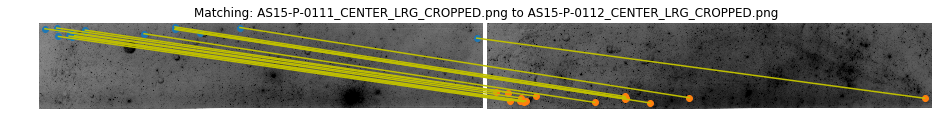

In [13]:
cg.edge[0][1].plot(clean_keys=['threshold'], downsampling=True)